##### Student Name: Nayem Alam
##### Student ID  : 260743549
##### Assignment 2

## Part 2.1 - SIFT
    Q. 1,2,3,4 - SIFT

### 1. Compute SIFT keypoints and corresponding descriptors for images 1Hill and 2Hill

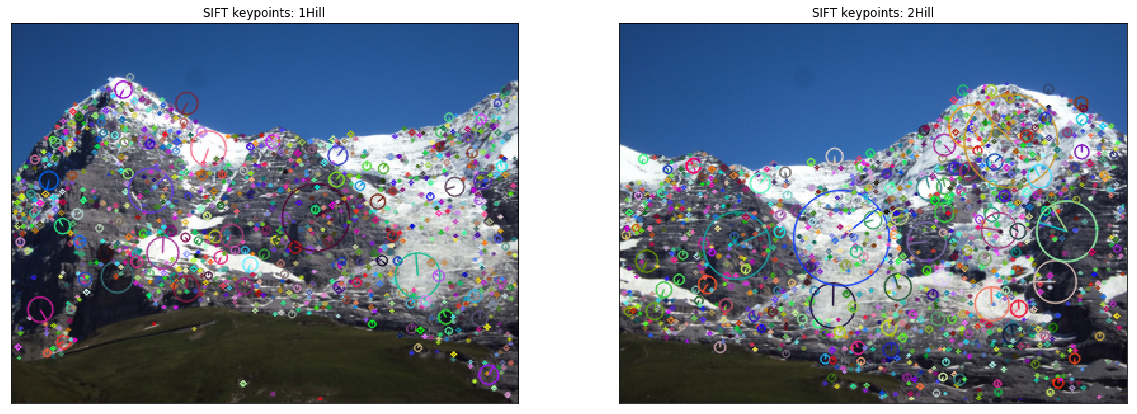

SIFT Total: (keypoints, descriptors) for 1Hill (1254, 128)
SIFT Total: (keypoints, descriptors) for 2Hill (1472, 128)


In [42]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# load and read image
firstPic = "./1Hill.JPG"
secondPic = "./2Hill.JPG"

oneHill = cv2.imread(firstPic)
twoHill = cv2.imread(secondPic)

# convert from BGR to RGB; so it's not blue colored pic
oneHillRGB = cv2.cvtColor(oneHill, cv2.COLOR_BGR2RGB)
twoHillRGB = cv2.cvtColor(twoHill, cv2.COLOR_BGR2RGB)

# output copies
oneHilldisp = oneHillRGB.copy()
twoHilldisp = twoHillRGB.copy()

# initiate SIFT, compute keypoints and descriptors
siftImg = cv2.xfeatures2d.SIFT_create()
keypoints1, descriptors1 = siftImg.detectAndCompute(oneHillRGB, None)
keypoints2, descriptors2 = siftImg.detectAndCompute(twoHillRGB, None)

# draw keypoints for sift
drawKeypts1 = cv2.drawKeypoints(oneHillRGB, keypoints1, oneHilldisp, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
drawKeypts2 = cv2.drawKeypoints(twoHillRGB, keypoints2, twoHilldisp, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure(figsize=(20,20))
plt.subplot(121), plt.imshow(oneHilldisp)
plt.title("SIFT keypoints: 1Hill"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(twoHilldisp)
plt.title("SIFT keypoints: 2Hill"), plt.xticks([]), plt.yticks([])
plt.show()

# to test for myself
print('SIFT Total: (keypoints, descriptors) for 1Hill', str(descriptors1.shape))
print('SIFT Total: (keypoints, descriptors) for 2Hill', str(descriptors2.shape))

### 2. Find matching keypoints in two images and display the 20 best pairs.

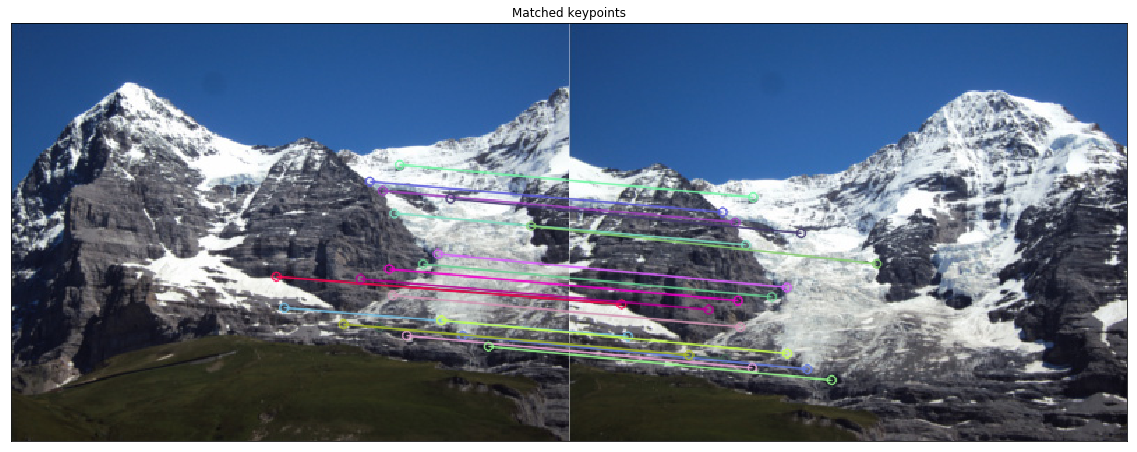

Number of matches:  20


In [43]:
# matching using brute force (taking the descriptor of one feature from first set to other features in second set)
bf = cv2.BFMatcher()

# match descriptors
matches = bf.match(descriptors1,descriptors2)

# sort in order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

# draw 20 best matches
bestMatches = matches[:20]
imgMatch = cv2.drawMatches(oneHillRGB,keypoints1,twoHillRGB,keypoints2, bestMatches, oneHillRGB, flags=2)

plt.figure(figsize=(20,20))
plt.imshow(imgMatch)
plt.title("Matched keypoints"), plt.xticks([]), plt.yticks([])
plt.show()

# to test
print("Number of matches: ",len(bestMatches))

### 3. Find homography using RANSAC method and apply transformation to 1Hill. Image 2Hill should not be transformed.

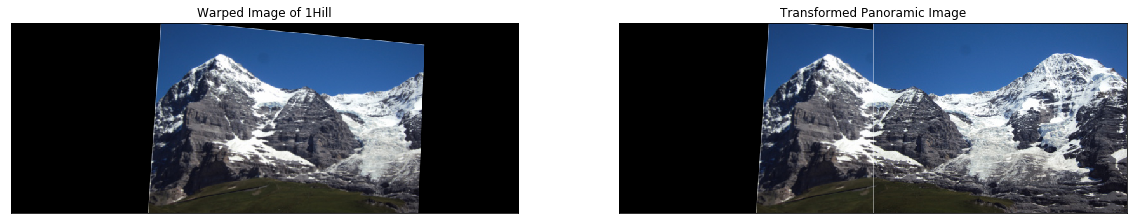

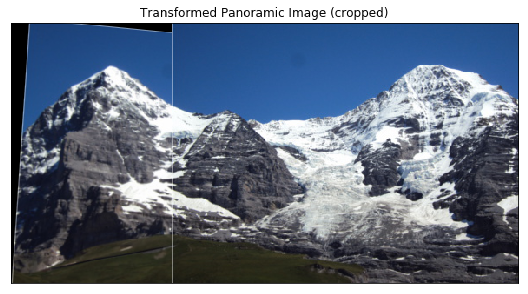

In [44]:
# Arrange matching keypoints in two separate lists
oneHillC = oneHillRGB.copy()
twoHillC = twoHillRGB.copy()

# extract location of good matches
GoodMatches = []
for idx, match in enumerate(matches):
    GoodMatches.append((match.trainIdx, match.queryIdx))
    
# GoodMatches = GoodMatches[:-1]
mp2 = np.float32([keypoints2[idx].pt for (idx, __) in GoodMatches])
mp1 = np.float32([keypoints1[idx].pt for (__, idx) in GoodMatches])

# shift points to overlap
for i in range(len(mp2)):
    mp2[i][0] += twoHillC.shape[1]

# find homography and wrap image accordingly
h, mask = cv2.findHomography(mp1, mp2, cv2.RANSAC, 5)

# apply transformation (only to 1Hill.JPG)
wimg = cv2.warpPerspective(oneHillC, h, (oneHillC.shape[1]+twoHillC.shape[1], oneHillC.shape[0]))
oneHillCRotate = wimg.copy() # clone transformed img1 for pyramid

# stitch
wimg[:,twoHillC.shape[1]:,:] = twoHillC
wimgNormal = wimg.copy()

# crop image
wimg = wimg[:,215:]
wholeHalfHillOutput = wimg.copy() # clone whole img for pyramid

plt.figure(figsize=(20,20))
plt.subplot(321)
plt.imshow(oneHillCRotate)
plt.title("Warped Image of 1Hill"), plt.xticks([]), plt.yticks([])
plt.subplot(322)
plt.imshow(wimgNormal)
plt.title("Transformed Panoramic Image"), plt.xticks([]), plt.yticks([])
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(wimg)
plt.title("Transformed Panoramic Image (cropped)"), plt.xticks([]), plt.yticks([])
plt.show()

# -- to note -- 
# .shape[0] = height
# .shape[1] = width
# .shape[2] = depth

# # to test for myself
# print("img1 height: ", oneHillC.shape[0])
# print("img2 height: ", twoHillC.shape[0])
# print("img1 width: ", oneHillC.shape[1])
# print("img2 width: ", twoHillC.shape[1])

### 4. Stitch transformed 1Hill and original 2Hill together using pyramid image blending.

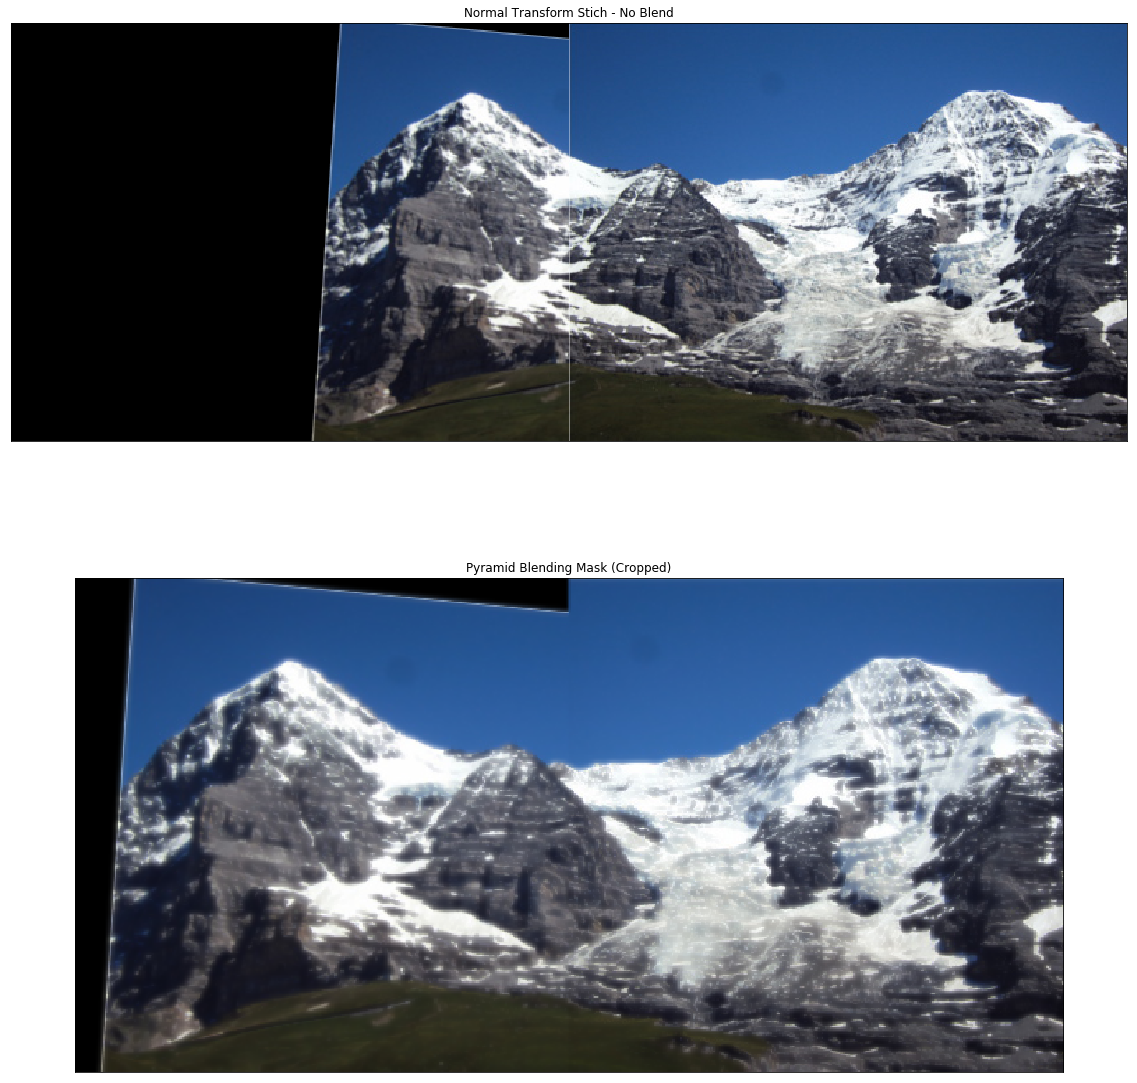

In [53]:
# make copies of copies to use here
imgA = oneHillCRotate
imgB  = cv2.copyMakeBorder(twoHillC, 0, 0, oneHillC.shape[1], 0, cv2.BORDER_CONSTANT,value=0)

# crop for blending nicely
imgA  = imgA[:, 200:]   
imgB  = imgB[:, 200:]

# set parameters: gaussian blur size and the pyramid depth size 
g_size = 255  # gaussian mask blur size
depth = 2  # pyramid depth size
""" PYRAMID BLENDING """
row, col, dpt = imgA.shape

# generate Gaussian pyramid for imgA
gImgA = imgA.copy()
gp1 = [gImgA]

for i in range(depth):
    gImgA = cv2.pyrDown(gImgA)
    gp1.append(gImgA)

# generate Gaussian pyramid for imgB
gImgB = imgB.copy()
gp2 = [gImgB]
for i in range(depth):
    gImgB = cv2.pyrDown(gImgB)
    gp2.append(gImgB)

# generate Laplacian pyramid for imgA
lp1 = [gp1[depth-1]]  # store last gaussian image for top of laplace pyramid
for i in range(depth-1,0,-1):
    # upsample lower pyramid
    hr = cv2.pyrUp(gp1[i], dstsize=(gp1[i-1].shape[1], gp1[i-1].shape[0]))
    lp = cv2.subtract(gp1[i-1], hr, cv2.CV_32F)  # subtract different levels
    lp1.append(lp)

# generate Laplacian pyramid for imgB
lp2 = [gp2[depth-1]]  # store last gaussian image for top of lp pyramid
for i in range(depth-1,0,-1):
    # upsample lower pyramid
    hr = cv2.pyrUp(gp2[i], dstsize=(gp2[i-1].shape[1], gp2[i-1].shape[0]))
    lp = cv2.subtract(gp2[i-1], hr, cv2.CV_32F)  # subtract different levels
    lp2.append(lp)

# add left and right halves of images in each level
LP = []
for la, lb in zip(lp1, lp2):
    row, cols, dpt = la.shape
    # stack columns (half and half)
    lp = np.hstack((la[:, :round(cols/2)], lb[:, round(cols/2):]))
    LP.append(lp)

# build Gaussian pyramid from selected region
mask = np.zeros((imgA.shape[1], imgA.shape[0]))
# create mask
mask[:, round(imgA.shape[1]/2):] = 1
# blur mask
mask = cv2.GaussianBlur(mask, (g_size, g_size), 0)

# generate Gaussian pyramid
GP = mask.copy()
GPR = [GP]

for i in range(depth):
    GP = cv2.pyrDown(GP)
    GPR.append(GP)

# add left and right halves of images in each level using Gaussian mask
LP_mask = []
i = 1
for la, lb in zip(lp1, lp2):
    idx = depth - i

    # Now blend
    lp = (1-GPR[idx].reshape(GPR[idx].shape[1],GPR[idx].shape[0],1)) * la + \
         GPR[idx].reshape(GPR[idx].shape[1],GPR[idx].shape[0],1) * lb
    lp = np.uint8(lp)  # convert back to uint8
    LP_mask.append(lp)
    i += 1

# now reconstruct
rs = LP[0]
for i in range(1, depth):
    rs = cv2.pyrUp(rs,dstsize= (LP_mask[i].shape[1], LP_mask[i].shape[0]))  # upsample current lp image
    rs = cv2.add(rs, LP[i])  # add lp image

# display results
plt.figure(figsize=(20,20))
plt.subplot(211), plt.imshow(wimgNormal)
plt.title('Normal Transform Stich - No Blend'), plt.xticks([]), plt.yticks([])
plt.subplot(212), plt.imshow(rs)
plt.title('Pyramid Blending Mask (Cropped)'), plt.xticks([]), plt.yticks([])
plt.show()


## Part 2.1 - SURF
    Q. 1,2,3,4 - SURF

In [54]:
### 1. Compute SURF keypoints and corresponding descriptors for images 12Hill and 3Hill.

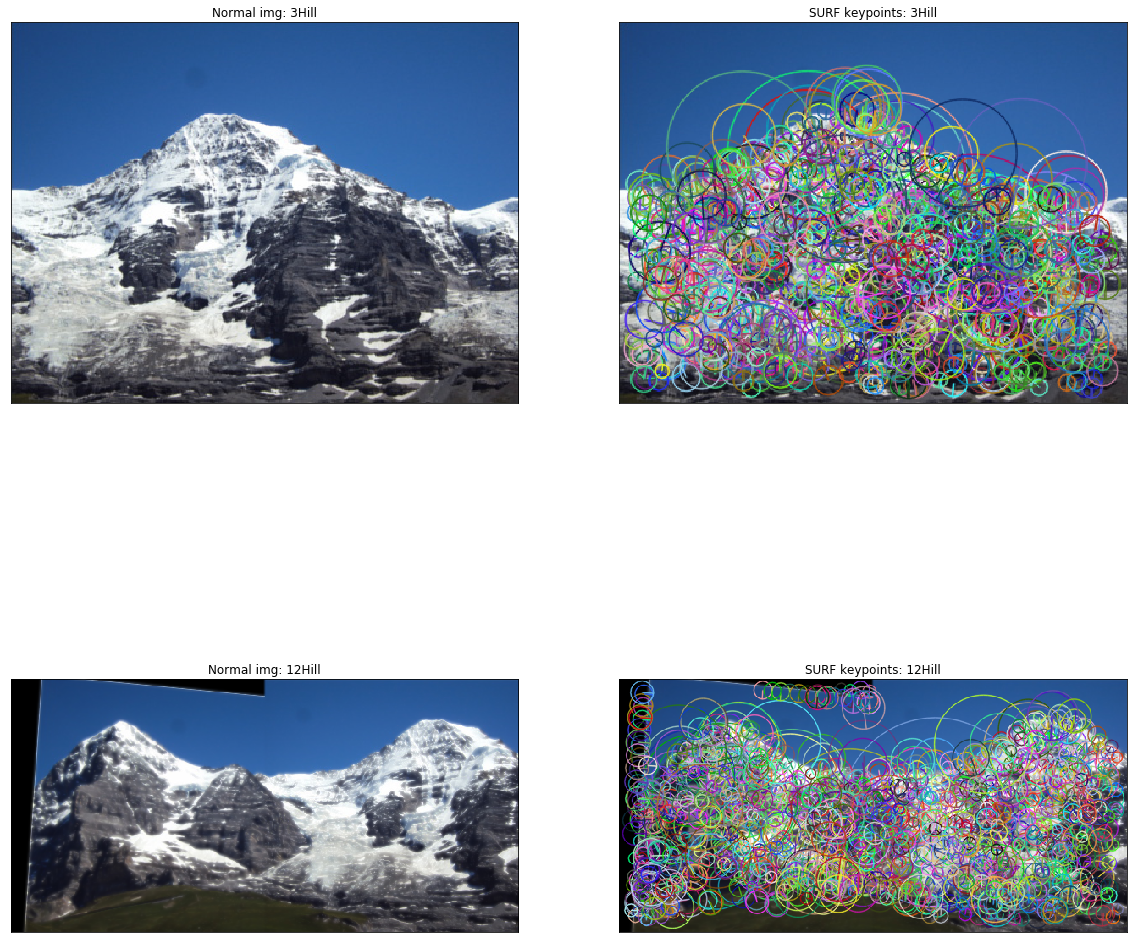

Number of keypoints for 3Hill: 879
Number of keypoints for 12Hill: 1276


In [55]:
# load and copy images
thirdPic = "./3Hill.JPG"

threeHill = cv2.imread(thirdPic)
threeHilldisp = threeHill.copy()

twelveHill = rs.copy()
twelveHilldisp = twelveHill.copy()

# convert to grayscale
three_gray = cv2.cvtColor(threeHill, cv2.COLOR_BGR2GRAY)
twelve_gray = cv2.cvtColor(twelveHill, cv2.COLOR_RGB2GRAY)

# convert to RGB
threeHill = cv2.cvtColor(threeHill, cv2.COLOR_BGR2RGB)
threeHilldisp = cv2.cvtColor(threeHilldisp, cv2.COLOR_BGR2RGB)

# create SURF object and detect features
surf = cv2.xfeatures2d.SURF_create()
keypoints3, descriptors3 = surf.detectAndCompute(three_gray, None)
keypoints12, descriptors12 = surf.detectAndCompute(twelve_gray, None)

cv2.drawKeypoints(threeHill, keypoints3, threeHilldisp, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv2.drawKeypoints(twelveHill, keypoints12, twelveHilldisp, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# plot
plt.figure(figsize=(20,20))
plt.subplot(221), plt.imshow(threeHill)
plt.title("Normal img: 3Hill"), plt.xticks([]), plt.yticks([])
plt.subplot(222), plt.imshow(threeHilldisp)
plt.title("SURF keypoints: 3Hill"), plt.xticks([]), plt.yticks([])
plt.subplot(223), plt.imshow(twelveHill)
plt.title("Normal img: 12Hill"), plt.xticks([]), plt.yticks([])
plt.subplot(224), plt.imshow(twelveHilldisp)
plt.title("SURF keypoints: 12Hill"), plt.xticks([]), plt.yticks([])
plt.show()

# number of SURF keypoints
print("Number of keypoints for 3Hill: " + str(len(keypoints3)))
print("Number of keypoints for 12Hill: " + str(len(keypoints12)))

### 2. Find matching keypoints in two images and display the 20 best pairs.

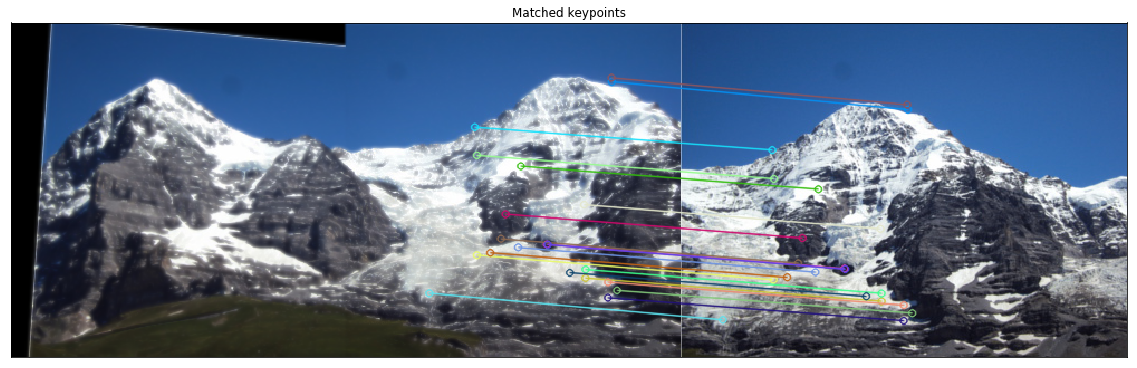

Number of matches:  20


In [56]:
threeHill_copy = threeHill.copy()
twelveHill_copy = twelveHill.copy()
# matching using brute force (taking the descriptor of one feature from first set to other features in second set)
bf2 = cv2.BFMatcher()

# match descriptors
matches1 = bf2.match(descriptors12,descriptors3)

# sort in order of their distance.
matches1 = sorted(matches1, key = lambda x:x.distance)

# draw 20 best matches
bestMatches1 = matches1[:20]
imgMatchNew = cv2.drawMatches(twelveHill_copy,keypoints12,threeHill_copy,keypoints3, bestMatches1, twelveHill_copy, flags=2)

plt.figure(figsize=(20,20))
plt.imshow(imgMatchNew)
plt.title("Matched keypoints"), plt.xticks([]), plt.yticks([])
plt.show()

# to test
print("Number of matches: ",len(bestMatches1))

### 3. Find homography using RANSAC method and apply transformation to 3Hill. Image 12Hill should not be transformed.

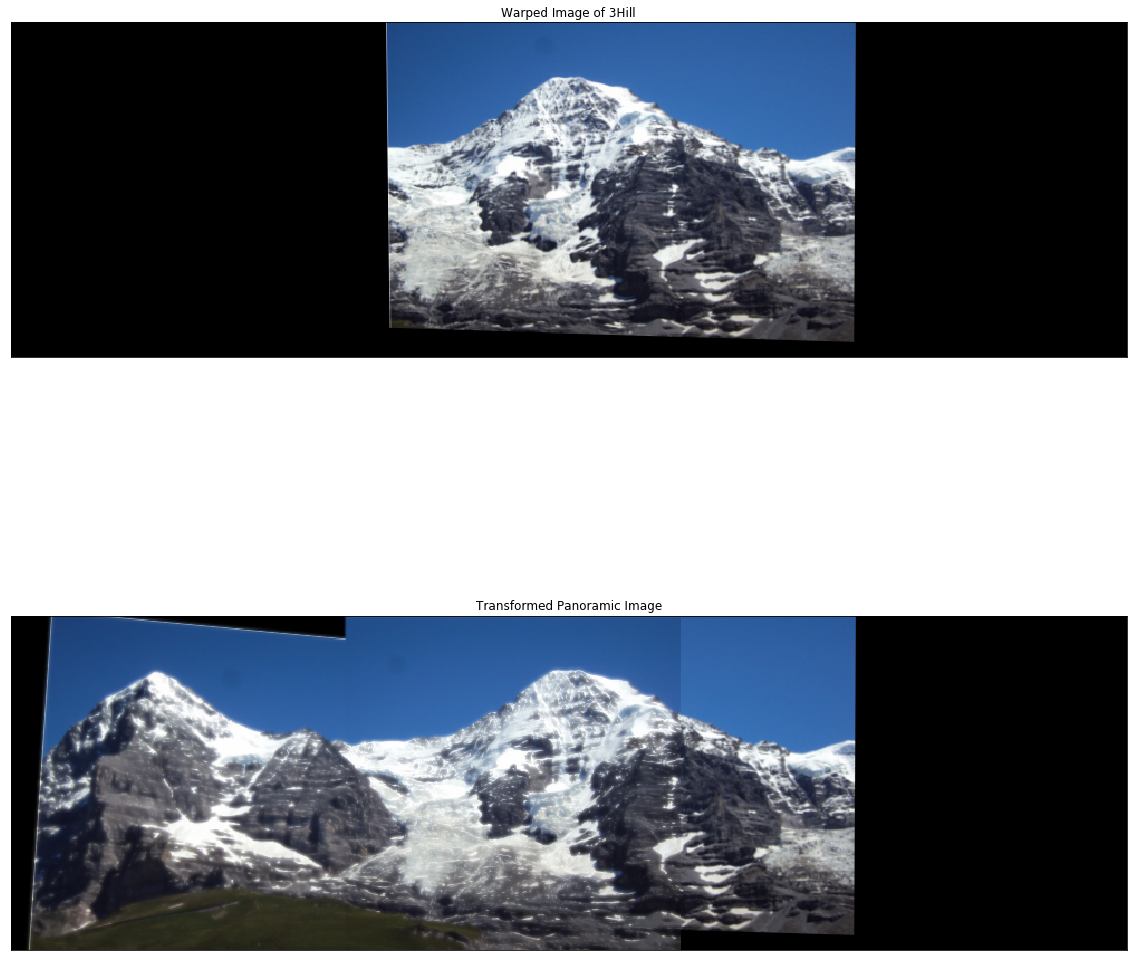

In [57]:
threeHillC = threeHill.copy()
twelveHillC = twelveHill.copy()
# extract location of good matches
GoodMatches = []
for i, m in enumerate(matches1):
    GoodMatches.append((m.trainIdx, m.queryIdx))
    
# GoodMatches = GoodMatches[:-1]
mp12 = np.float32([keypoints12[i].pt for (__, i) in GoodMatches])
mp3 = np.float32([keypoints3[i].pt for (i, __) in GoodMatches]) 

# find homography and wrap image accordingly
H, M = cv2.findHomography(mp3, mp12, cv2.RANSAC, 4)

# apply transformation (only to 1Hill.JPG)
wimg2 = cv2.warpPerspective(threeHillC, H, (twelveHillC.shape[1]+threeHillC.shape[1], twelveHillC.shape[0]))
threeHillCRotate = wimg2.copy() # clone transformed img3 for linear

# stitch
# wimg2[:,twelveHillC.shape[1]:,:] = twelveHillC
wimg2[:,:twelveHillC.shape[1],:] = twelveHillC
wimgNormal2 = wimg2.copy()

# crop image
wimg2 = wimg2[:400,:700]
wholeHalfHillOutput = wimg2.copy()

plt.figure(figsize=(20,20))
plt.subplot(211), plt.imshow(threeHillCRotate)
plt.title("Warped Image of 3Hill"), plt.xticks([]), plt.yticks([])
plt.subplot(212), plt.imshow(wimgNormal2)
plt.title("Transformed Panoramic Image"), plt.xticks([]), plt.yticks([])
plt.show()

### 4. Stitch transformed 3Hill and 12Hill together and apply linear image blending.

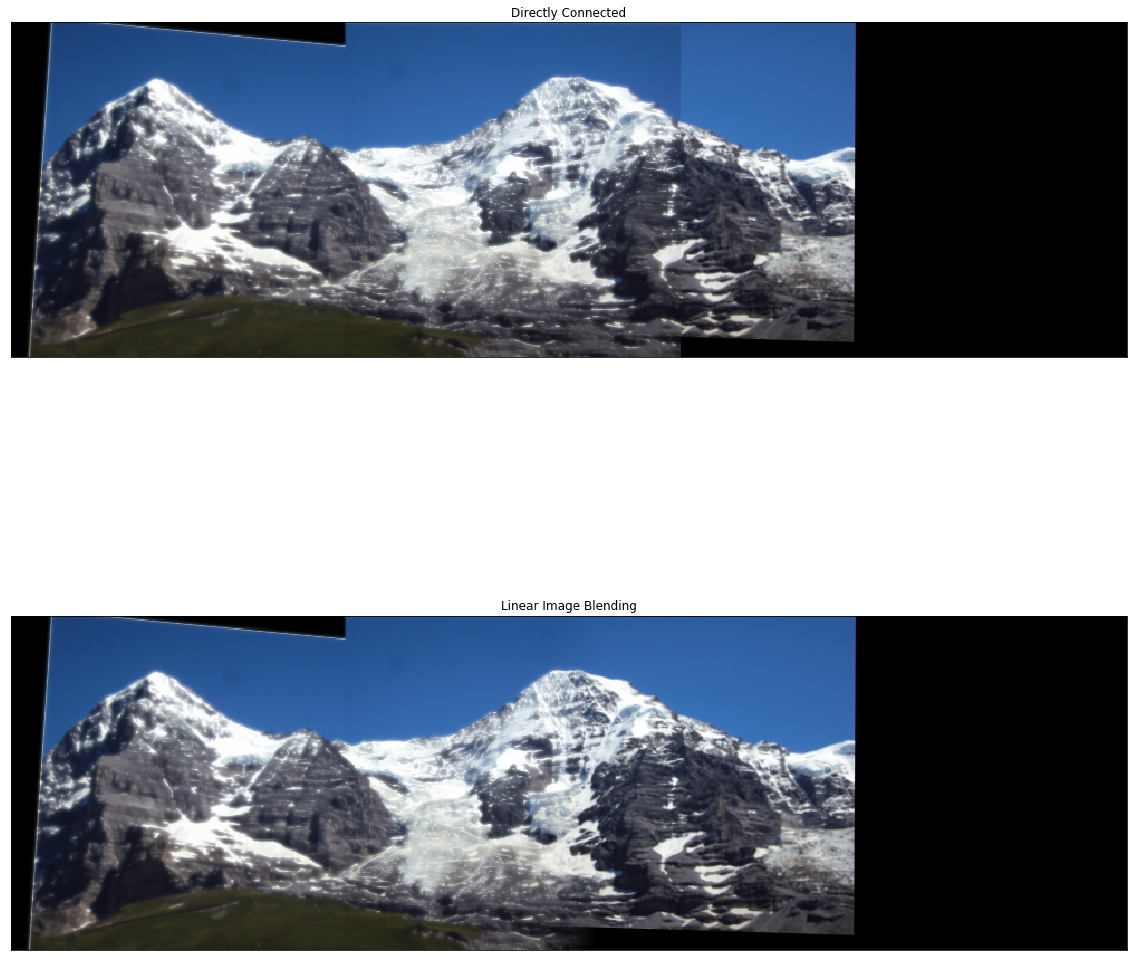

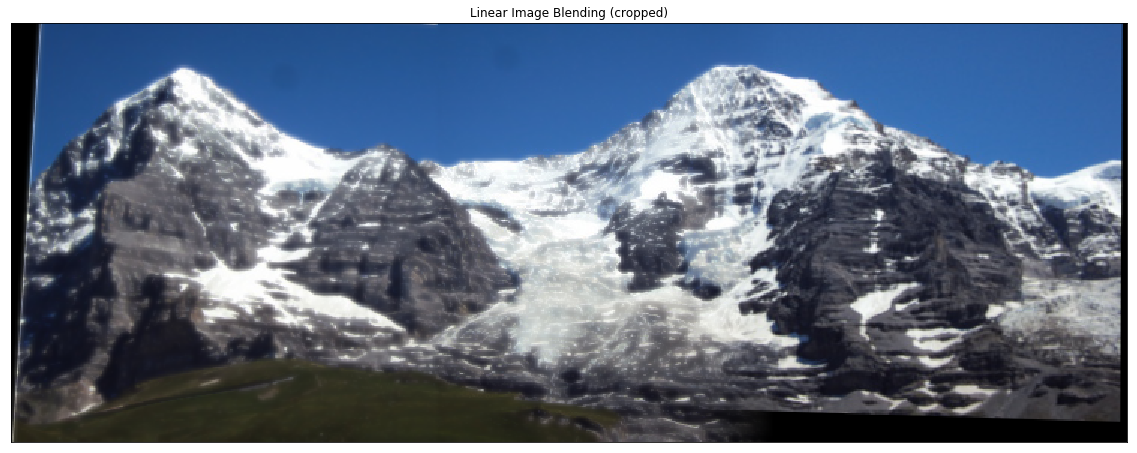

In [58]:
# read images
A = cv2.copyMakeBorder(twelveHillC, 0, 0, 0, threeHillC.shape[1], cv2.BORDER_CONSTANT,value=0)
B = threeHillCRotate

# image with direct connecting each half
real = np.hstack((A[:, :twelveHill.shape[1],:], B[:, twelveHill.shape[1]:,:])).astype(np.uint8)

""" ALPHA BLENDING """
def Ramp(i_width, r_width, r_index, start, end):
    """
    Create alpha blending function
    :param i_width: img width
    :param r_width: ramp width
    :param r_index: center ramp index
    :param start: starting ramp value
    :param end: ending ramp value
    :return:
    """
    a = np.zeros((i_width))
    step = (end - start) / (r_width-1)
    idx = round(r_index - (r_width / 2))  # left side starting index of alpha ramp
    for i in range(r_width):
        a[idx] = start + step*i
        idx += 1
    a[idx:] = 1
    return a

# alpha blending ramp
ramp_size = 50  # alpha blending ramp size
alpha = Ramp(A.shape[1], ramp_size, round(A.shape[1]/2), 0, 1)

# Now blend
I_blend = (1-alpha.reshape(1,-1,1)) * A + alpha.reshape(1,-1,1)*B
I_blend = np.uint8(I_blend)  # convert back to uint8

# display images
plt.figure(figsize=(20,20))
plt.subplot(211), plt.imshow(real)
plt.title("Directly Connected"), plt.xticks([]), plt.yticks([])
plt.subplot(212), plt.imshow(I_blend)
plt.title("Linear Image Blending"), plt.xticks([]), plt.yticks([])

I_blend = I_blend[20:400,15:760]
plt.figure(figsize=(20,20))
plt.subplot(111)
plt.imshow(I_blend)
plt.title("Linear Image Blending (cropped)"), plt.xticks([]), plt.yticks([])

plt.show()

### 2.2 Reasoning Questions

#### 1. What are the differences between SIFT and SURF? Comment on the speed, number of keypoints and density. Support your arguments with statistics. 

SIFT (Scale-invariant feature transform) and SURF (Speeded Up Robust Features) are both feature matching algorithms. 

* <b>SIFT: includes</b>
    - Image pyramid
    - Key points finding
    - Refining key points
    - Key points orientation assignment
    - Local image descriptor
    <br><br>
One of the components we used for this code, the detector, it uses a difference of gaussian (DoG) which is an approximation of laplacian and this is for "scale invariant," which allows us to detect key points in different scales and detect centers of blob-like structures. 
<br><br>

* <b>SURF:</b>  
As the name suggests, the SURF (Speeded Up Robust Features) is a faster version of SIFT. Instead of using DoG, it uses an integer approximation to the determinant of Hessian blob detector. This allows SURF to find more keypoints compared to SIFT. Whereas SURF uses different scales of Gaussian masks, while the scale of image isn't altered. We end up saving a lot of time by not downsampling image.

#### 2. Discuss at least two pros and cons of pyramid and linear blending techniques. When should one prefer pyramid blending over linear blending?

* Pyramid blending:
    - <b>Pro:</b> 
        - Pyramid blending breaks down the image into multiple levels and they are kept in a stack like a pyramid, with biggest image at bottom and smallest image at top.In this case of our assignment, stacking two images together creates weird discontinuities between the images. For example, the contrast between the white snow and the dark rocks, we can see that it is able to blend very well depending on the depth (level) of the image being used.  
    - <b>Con:</b> 
        - One con about pyramid blending is that it depends on the depth, by depending on the depth of the images, it requires extra code and memory to create the blend, i.e. takes a longer time to execute.
    
    
* Linear blending: 
    - <b>Pro:</b> 
        - Linear blending is faster and easier to implement as we can see from the codes above (Part 2.1. SURF Q.4 vs Part 2.1 SIFT Q.4). As a result, the process for combining two images togeter is not that complex. 
    - <b>Con:</b> 
        - It takes the weighted average of every pixel and the weight of the pixel is dependant on the distance from the map. By doing so, it's not always able to blend images together accurately as it requires a balance between the smoothing low frequencies. In the case of the mountain images, to blend them together worked out completely fine as the color contrast between the images are very similar (sky, rocks).
        
One should prefer pyramid over linear when operating at high frequencies. 

#### 3. What would happen if a random subset of pairs of matching keypoints is used for finding homography? 
Using a random set of pairs entails having a mixture of both good and bad pairs to match the keypoints. In doing so, this would result in homography worse than our analysis on the HILL pictures, and would possibly lead to misaligned images; poor image synthesis. 

#### 4. Discuss the relationship between the number of pairs of matching keypoints used for finding homography and the accuracy of inferred homography.

Any two image consisting of the same planar surface are related by a certain homography. The goal is to have more good points to match. If we have too many points, then that might hinder finding good points (because more points can include bad points as well on the images). As a result, for this assignment we used 20 matches and these would be used as the <i>best matches.</i>